## Scrape data

In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page to scrape
# url = "https://paperswithcode.com/sota/multi-task-language-understanding-on-mmlu" # MMLU
# url = "https://paperswithcode.com/sota/sentence-completion-on-hellaswag" # Hellaswag
url = "https://paperswithcode.com/sota/common-sense-reasoning-on-arc-challenge" # ARC

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')
scripts = soup.find_all('script')

chart_data, table_metrics, table_data = scripts[6:9]

import json
json_table = json.loads(table_data.string)

df  = pd.DataFrame(json_table)
# MMLU
# df.to_csv('mmlu_data/mmlu_benchmark_results.csv')
# df = df.drop(columns=['table_id', 'mlmodel', 'mlmodeldetails', 'mlmodel_short', 'external_source_url', 'reports'])
# df['mmlu_accuracy'] = df.raw_metrics.apply(lambda x: x['Average (%)'])
# df.to_csv('mmlu_data/mmlu_benchmark_results_clean.csv', index=False)

# Hellaswag
# df.to_csv('hellaswag_data/hellaswag_benchmark_results.csv')
# df = df.drop(columns=['table_id', 'mlmodel', 'mlmodeldetails', 'mlmodel_short', 'external_source_url', 'reports'])
# df['hellaswag_accuracy'] = df.raw_metrics.apply(lambda x: x['Accuracy'])
# df.to_csv('hellaswag_data/hellaswag_benchmark_results_clean.csv', index=False)

# ARC
df.to_csv('arc_data/arc_benchmark_results.csv')
df = df.drop(columns=['table_id', 'mlmodel', 'mlmodeldetails', 'mlmodel_short', 'external_source_url', 'reports'])
df['arc_accuracy'] = df.raw_metrics.apply(lambda x: x['Accuracy'])
df.to_csv('arc_data/arc_benchmark_results_clean.csv', index=False)


In [18]:
import pandas as pd

# Read the datasets
mmlu_df = pd.read_csv('mmlu_data/mmlu_benchmark_results_clean_labeled.csv')
arc_df = pd.read_csv('arc_data/arc_benchmark_results_clean.csv')
hellaswag_df = pd.read_csv('hellaswag_data/hellaswag_benchmark_results_clean.csv')

# Function to strip whitespace and convert to lowercase
def clean_string(s):
    return s.strip().lower() if isinstance(s, str) else s

# Apply cleaning to method_short in all datasets
mmlu_df['method_short_clean'] = mmlu_df['method_short'].apply(clean_string)
arc_df['method_short_clean'] = arc_df['method_short'].apply(clean_string)
hellaswag_df['method_short_clean'] = hellaswag_df['method_short'].apply(clean_string)

# Create a dictionary mapping cleaned method_short to open_weights from MMLU dataset
open_weights_dict = dict(zip(mmlu_df['method_short_clean'], mmlu_df['open_weights']))

# Update ARC dataset
arc_df['open_weights'] = arc_df['method_short_clean'].map(open_weights_dict)

# Update Hellaswag dataset
hellaswag_df['open_weights'] = hellaswag_df['method_short_clean'].map(open_weights_dict)

# Remove the temporary cleaned column
arc_df = arc_df.drop(columns=['method_short_clean'])
hellaswag_df = hellaswag_df.drop(columns=['method_short_clean'])

# Save updated datasets
arc_df.to_csv('arc_data/arc_benchmark_results_clean_labeled.csv', index=False)
hellaswag_df.to_csv('hellaswag_data/hellaswag_benchmark_results_clean_labeled.csv', index=False)

# Print some information about the updates
print(f"ARC dataset: {arc_df['open_weights'].notna().sum()} rows updated with open_weights")
print(f"Hellaswag dataset: {hellaswag_df['open_weights'].notna().sum()} rows updated with open_weights")

ARC dataset: 20 rows updated with open_weights
Hellaswag dataset: 19 rows updated with open_weights


In [11]:
# Did some manual labeling of whether weights were openly available or not -> new CSV file.
# this could probably be automated by checking against the names of the other dataset, but it wasn't standardized

## Plots

### Data Prep

In [1]:
import pandas as pd
import numpy as np

# Set up the data
df_research = pd.read_csv('papers_with_models.csv')
df_released = pd.read_csv('Epoch Database - Notable Systems.csv')

df_research['date'] = pd.to_datetime(df_research['publication date (first revision)'])
df_research['year'] = pd.to_datetime(df_research['date']).dt.year
df_research['param count'] = pd.to_numeric(df_research['param count'], errors='coerce')
df_research['mmlu_accuracy'] = pd.to_numeric(df_research['mmlu_accuracy'], errors='coerce')
df_research['hellaswag_accuracy'] = pd.to_numeric(df_research['hellaswag_accuracy'], errors='coerce')
df_research['arc_accuracy'] = pd.to_numeric(df_research['arc_accuracy'], errors='coerce')
df_research['Type'] = 'Models used in research'

df_released['date'] = pd.to_datetime(df_released['Publication date'])
df_released['year'] = df_released['date'].dt.year
df_released['param count'] = pd.to_numeric(df_released['Parameters'], errors='coerce')
df_released['Type'] = 'Models released'

In [2]:
from scipy import interpolate

# Prep the dataset of research models
df_research = df_research.sort_values(['date', 'param count'])

# Create masks for rows with missing accuracies
mmlu_mask = df_research['mmlu_accuracy'].isna() | (df_research['mmlu_accuracy'] == 0)
hellaswag_mask = df_research['hellaswag_accuracy'].isna() | (df_research['hellaswag_accuracy'] == 0)
arc_mask = df_research['arc_accuracy'].isna() | (df_research['arc_accuracy'] == 0)

# Perform nearest neighbor interpolations

f = interpolate.interp1d(df_research.loc[~mmlu_mask, 'param count'], 
                         df_research.loc[~mmlu_mask, 'mmlu_accuracy'], 
                         kind='nearest')
df_research.loc[mmlu_mask, 'mmlu_accuracy'] = f(df_research.loc[mmlu_mask, 'param count'])

f = interpolate.interp1d(df_research.loc[~hellaswag_mask, 'param count'], 
                         df_research.loc[~hellaswag_mask, 'hellaswag_accuracy'], 
                         kind='nearest')
df_research.loc[hellaswag_mask, 'hellaswag_accuracy'] = f(df_research.loc[hellaswag_mask, 'param count'])

f = interpolate.interp1d(df_research.loc[~arc_mask, 'param count'], 
                         df_research.loc[~arc_mask, 'arc_accuracy'], 
                         kind='nearest')
df_research.loc[arc_mask, 'arc_accuracy'] = f(df_research.loc[arc_mask, 'param count'])


In [3]:
# Prep the dataset of released models
df_released = df_released[(df_released['year'] >= 2019) & 
                            (df_released['year'] <= 2024)]


df_released = df_released.sort_values(by='date')
df_released = df_released[df_released['Domain'].str.contains('Language')]
df_released = df_released[df_released['Model accessibility'].str.contains('Open access', na=False)]

# Filter out rows with NaN in 'param_count'
df_released = df_released.dropna(subset=['param count'])

In [4]:
# Combine both DataFrames
df_combined = pd.concat([df_research[['year', 'date', 'param count', '' 'Type']], 
                         df_released[['year', 'date', 'param count', 'Type']]], ignore_index=True)

In [5]:
def get_max_list(df, metric='mmlu_accuracy'):
    max_score = 0
    max_score_list = []

    for i,x in df.iterrows():

        if x[metric] > max_score:
            max_score = x[metric]
            if len(max_score_list) == 0:
                max_score_list.append(x)
            else:
                if max_score_list[-1].evaluation_date == x.evaluation_date:
                    max_score_list[-1] = x
                else:
                    max_score_list.append(x)

    return max_score_list


In [6]:
# Define color palette
palette = {
    "bg_light_blue": "#93bed9",
    "bg_dark_blue": "#52778d",
    "bg_very_light_blue": "#c9eafb",
    "bg_brown": "#8c6443",
    "bg_light_brown": "#d8b294",
    "bg_muted_brown": "#a68e82",
    "fg_bright_blue": "#2991cf",
    "fg_deep_blue": "#06608e",
    "fg_light_blue": "#4babe1",
    "fg_deep_brown": "#8c4720",
    "fg_bright_orange": "#da6f27",
    "fg_burnt_orange": "#a54a24",
    "contrast_light_blue": "#4babe1",
    "contrast_orange": "#ee8c44"
}

### MMLU Plot

In [7]:
import pandas as pd

# Set up a list of open and closed models with highest MMLU scores

mmlu_df  = pd.read_csv('mmlu_data/mmlu_benchmark_results_clean_labeled.csv')

mmlu_df['evaluation_date'] = pd.to_datetime(mmlu_df['evaluation_date'])
mmlu_df['open_weights'] = mmlu_df['open_weights'].astype(bool)
mmlu_df = mmlu_df[['rank', 'method_short', 'evaluation_date', 'mmlu_accuracy', 'open_weights']]

open_mmlu_df = mmlu_df[mmlu_df.open_weights == True].sort_values(by='evaluation_date', ascending=True)
closed_mmlu_df = mmlu_df[mmlu_df.open_weights == False].sort_values(by='evaluation_date', ascending=True)

max_closed = get_max_list(closed_mmlu_df)
max_open = get_max_list(open_mmlu_df)

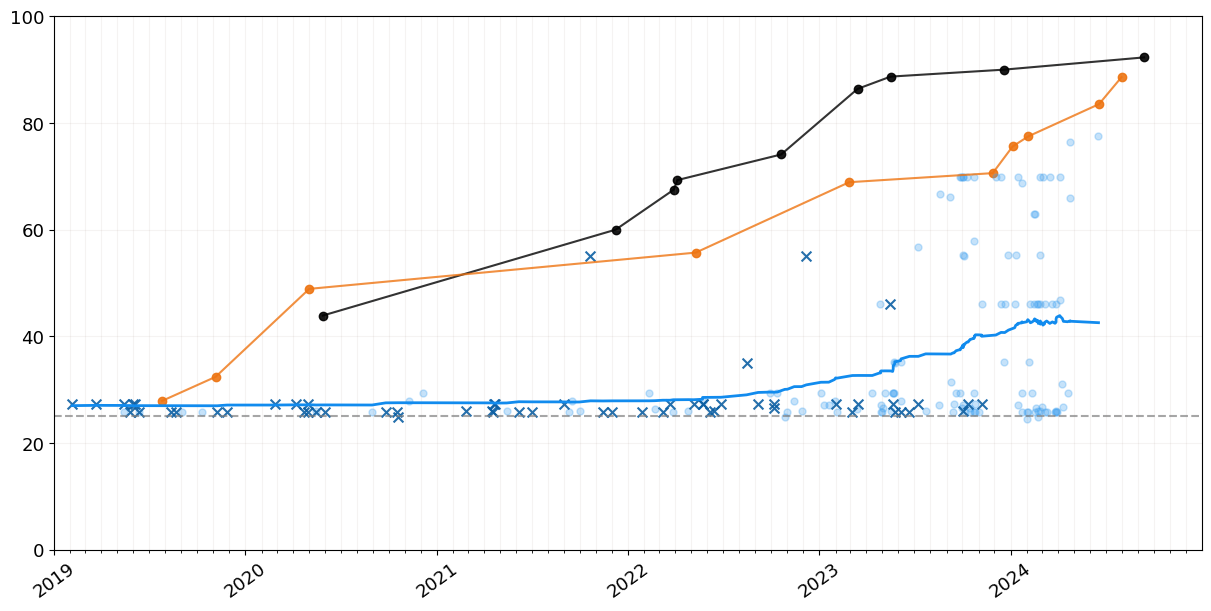

In [78]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Ensure the date column is in datetime format
df_research['date'] = pd.to_datetime(df_research['date'])

# Sort the dataframe by date
df_research = df_research.sort_values('date')


# Set up the plot
plt.figure(figsize=(12, 6))  # Increased figure size for better visibility
ax = plt.gca()

plt.plot([x.evaluation_date for x in max_closed], [x.mmlu_accuracy for x in max_closed], color='black', alpha=0.8, )
plt.scatter([x.evaluation_date for x in max_closed], [x.mmlu_accuracy for x in max_closed], 
            color='black', alpha=0.9, label='Highest scoring closed models') 

plt.plot([x.evaluation_date for x in max_open], [x.mmlu_accuracy for x in max_open], color='#EE7411', alpha=0.8)
plt.scatter([x.evaluation_date for x in max_open], [x.mmlu_accuracy for x in max_open], 
            color='#EE7411', alpha=0.9, label='Highest scoring open models')  

# Calculate the rolling average
window_size = 90
df_research['rolling_avg'] = df_research['mmlu_accuracy'].rolling(window=window_size, center=True, min_periods=1).mean()
# Plot the rolling average
plt.plot(df_research['date'], df_research['rolling_avg'], color="#118BEE", linewidth=2, label='90-day rolling average')

# Add horizontal dashed line for random baseline
plt.axhline(y=25, color='gray', linestyle='--', alpha=0.7, label='Random baseline (25%)')

# Add specific markers for Yi-34B and QWEN Chat 72B
# outlier_models = df_research[df_research['model'].isin(['Yi-34B', 'QWEN Chat 72B'])]

# plt.scatter(outlier_models['date'], outlier_models['mmlu_accuracy'], 
#             color=palette['fg_bright_blue'], s=50, marker='D', label='Outlier models')

# Filter out 60B-70B models
# models_60_70B = df_research[(df_research['param count'] >= 60e9) & (df_research['param count'] <= 70e9)]
# df_research = df_research[~df_research.index.isin(models_60_70B.index)]

# Plot original data points
plt.scatter(df_research.loc[~mmlu_mask, 'date'], 
            df_research.loc[~mmlu_mask, 'mmlu_accuracy'], 
            color="#41A2F1", alpha=0.3, s=25, label='Models with MMLU available')

# Plot interpolated data points with 'X' marker
plt.scatter(df_research.loc[mmlu_mask, 'date'], 
            df_research.loc[mmlu_mask, 'mmlu_accuracy'], 
            color="#0C5FA3", alpha=0.9, s=50, marker='x', label='Models with MMLU interpolated')

# # Plot original academic data points
# plt.scatter(df_research.loc[~mmlu_mask & ~df_research['non-academia'], 'date'], 
#             df_research.loc[~mmlu_mask & ~df_research['non-academia'], 'mmlu_accuracy'], 
#             color=palette['fg_bright_blue'], alpha=0.3, s=25, label='Models from academic papers with MMLU available')

# # Plot original non-academic data points
# plt.scatter(df_research.loc[~mmlu_mask & df_research['non-academia'], 'date'], 
#             df_research.loc[~mmlu_mask & df_research['non-academia'], 'mmlu_accuracy'], 
#             color='orange', alpha=0.3, s=25, label='Models from non-academic papers with MMLU available')

# # Plot interpolated academic data points with 'X' marker
# plt.scatter(df_research.loc[mmlu_mask & ~df_research['non-academia'], 'date'], 
#             df_research.loc[mmlu_mask & ~df_research['non-academia'], 'mmlu_accuracy'], 
#             color=palette['fg_bright_blue'], alpha=0.6, s=50, marker='x', label='Models from academic papers with MMLU interpolated')

# # Plot interpolated non-academic data points with 'X' marker
# plt.scatter(df_research.loc[mmlu_mask & df_research['non-academia'], 'date'], 
#             df_research.loc[mmlu_mask & df_research['non-academia'], 'mmlu_accuracy'], 
#             color='orange', alpha=0.6, s=50, marker='x', label='Models from non-academic papers with MMLU interpolated')

# Add markers for models with param count between 60B and 70B
# plt.scatter(models_60_70B['date'], models_60_70B['mmlu_accuracy'], 
#             color='purple', s=100, lw=3, marker='_', label='60B-70B models')

# # Academic models 60B-70B
# plt.scatter(models_60_70B[~models_60_70B['non-academia']]['date'], 
#             models_60_70B[~models_60_70B['non-academia']]['mmlu_accuracy'], 
#             color='purple', s=100, marker='_', lw=3, label='60B-70B models from academic papers')

# # Non-academic models 60B-70B
# plt.scatter(models_60_70B[models_60_70B['non-academia']]['date'], 
#             models_60_70B[models_60_70B['non-academia']]['mmlu_accuracy'], 
#             color='orange', s=100, marker='_', lw=3, label='60B-70B models from non-academic papers')


# # Create text annotations (unchanged)
# texts = []
# for point in max_closed:
#     texts.append(plt.text(point.evaluation_date, point.mmlu_accuracy, point.method_short,
#                         fontsize=9,
#                         bbox=dict(boxstyle="round,pad=0.3", fc=palette['bg_light_blue'], ec="gray", alpha=0.8)))
    
# for point in max_open:
#     texts.append(plt.text(point.evaluation_date, point.mmlu_accuracy, point.method_short,
#                         fontsize=9,
#                         bbox=dict(boxstyle="round,pad=0.3", fc=palette['bg_muted_brown'], ec="gray", alpha=0.8)))

# # Use adjust_text to prevent overlap (unchanged)
# adjust_text(texts, 
#             force_points=(0, 0),
#             force_text=(0.5, 1.2),
#             expand_points=(0, 0),
#             expand_text=(0.1, 0.5),
#             )

# # Set labels and title
# ax.set_title('MMLU Score Trends Comparison', fontsize=16)   
# ax.set_xlabel('Publication Date', fontsize=14)  
# ax.set_ylabel("MMLU Average (%)", fontsize=14)  

# Customize the x-axis (unchanged)
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Set font size for y-axis tick labels
ax.tick_params(axis='y', which='major', labelsize=13)  # Adjust the size (16) as needed
ax.tick_params(axis='y', which='minor', labelsize=13)  # Adjust the size (16) as needed
#ySet font size for y-axis tick labels and rotate them slightly
ax.tick_params(axis='x', which='major', labelsize=13, rotation=36)  # Adjust the size (16) and rotation (15) as needed
ax.tick_params(axis='x', which='minor', labelsize=13, rotation=36)  # Adjust the size (16) and rotation (15) as needed

# # Remove x-axis labels
# ax.set_xticklabels([])

# # Remove y-axis labels
# ax.set_yticklabels([])

# Set y-axis limits to 0-100
ax.set_ylim(0, 100)

# Customize the grid (unchanged)
plt.grid(True, which="both", ls="-", alpha=0.1, color=palette['bg_muted_brown'])

# Add legend
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot with tight layout
plt.tight_layout()
# Save the current figure as a PDF
plt.savefig('scatterplot.pdf', format='pdf', bbox_inches='tight')
plt.show()



### Hellaswag Plot

In [78]:
import pandas as pd
hellaswag_df  = pd.read_csv('hellaswag_data/hellaswag_benchmark_results_clean_labeled.csv')

hellaswag_df['evaluation_date'] = pd.to_datetime(hellaswag_df['evaluation_date'])
hellaswag_df['open_weights'] = hellaswag_df['open_weights'].map({'TRUE': True, 'FALSE': False})
hellaswag_df = hellaswag_df[['rank', 'method_short', 'evaluation_date', 'hellaswag_accuracy', 'open_weights']]

open_hellaswag_df = hellaswag_df[hellaswag_df.open_weights == True].sort_values(by='evaluation_date', ascending=True)
closed_hellaswag_df = hellaswag_df[hellaswag_df.open_weights == False].sort_values(by='evaluation_date', ascending=True)

max_closed = get_max_list(closed_hellaswag_df, metric='hellaswag_accuracy')
max_open = get_max_list(open_hellaswag_df, metric='hellaswag_accuracy')

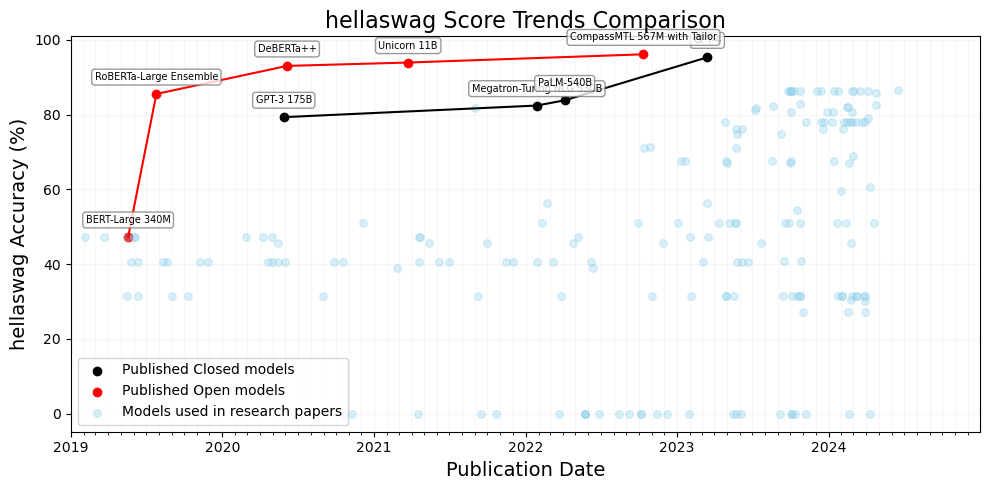

In [79]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Create scatter plot

plt.plot([x.evaluation_date for x in max_closed], [x.hellaswag_accuracy for x in max_closed], color='black')
plt.scatter([x.evaluation_date for x in max_closed], [x.hellaswag_accuracy for x in max_closed], color='black', label='Published Closed models')

plt.plot([x.evaluation_date for x in max_open], [x.hellaswag_accuracy for x in max_open], color='red')
plt.scatter([x.evaluation_date for x in max_open], [x.hellaswag_accuracy for x in max_open], color='red', label='Published Open models')

plt.scatter(df_research['date'], df_research['hellaswag_accuracy'], 
            color='skyblue', alpha=0.3, s=30, label='Models used in research papers')


# plt.hlines(25, pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'), linestyles=['dashed'], color='black', alpha=0.3)

# Add annotations for max_score_list points
for i, point in enumerate(max_closed):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.hellaswag_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

for i, point in enumerate(max_open):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.hellaswag_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Set y-axis to logarithmic scale
# plt.yscale('log')

# Set labels and title
ax.set_title('hellaswag Score Trends Comparison', fontsize=16)
ax.set_xlabel('Publication Date', fontsize=14)
ax.set_ylabel("hellaswag Accuracy (%)", fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.1)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

### ARC Plot

In [76]:
import pandas as pd
arc_df  = pd.read_csv('arc_data/arc_benchmark_results_clean_labeled.csv')

arc_df['evaluation_date'] = pd.to_datetime(arc_df['evaluation_date'])
arc_df['open_weights'] = arc_df['open_weights'].map({'TRUE': True, 'FALSE': False})
arc_df = arc_df[['rank', 'method_short', 'evaluation_date', 'arc_accuracy', 'open_weights']]

open_arc_df = arc_df[arc_df.open_weights == True].sort_values(by='evaluation_date', ascending=True)
closed_arc_df = arc_df[arc_df.open_weights == False].sort_values(by='evaluation_date', ascending=True)

max_closed = get_max_list(closed_arc_df, metric='arc_accuracy')
max_open = get_max_list(open_arc_df, metric='arc_accuracy')

AttributeError: 'Series' object has no attribute 'arc_accuracy'

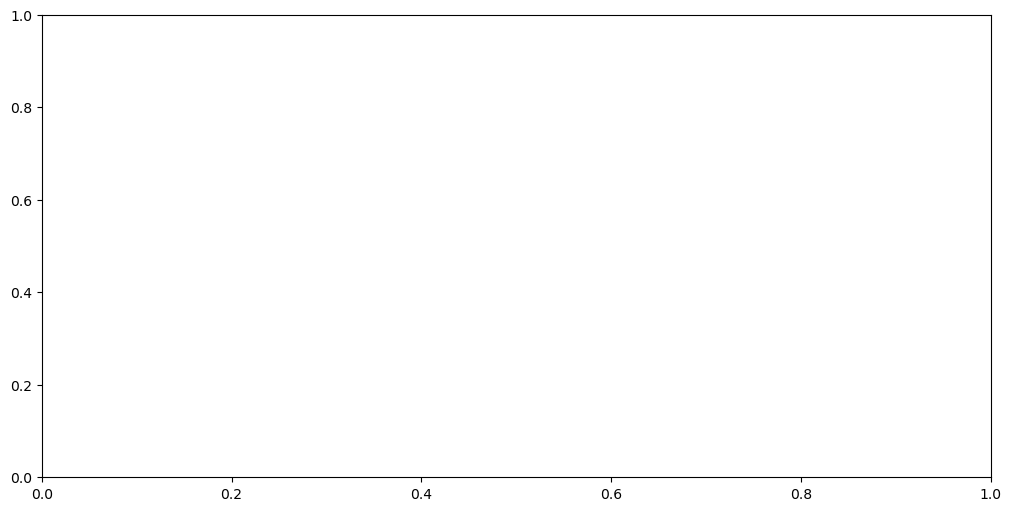

In [73]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Create scatter plot

plt.plot([x.evaluation_date for x in max_closed], [x.arc_accuracy for x in max_closed], color='black')
plt.scatter([x.evaluation_date for x in max_closed], [x.arc_accuracy for x in max_closed], color='black', label='Published Closed models')

plt.plot([x.evaluation_date for x in max_open], [x.arc_accuracy for x in max_open], color='red')
plt.scatter([x.evaluation_date for x in max_open], [x.arc_accuracy for x in max_open], color='red', label='Published Open models')

plt.scatter(df_research['date'], df_research['arc_accuracy'], 
            color='skyblue', alpha=0.3, s=30, label='Models used in research papers')


# plt.hlines(25, pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'), linestyles=['dashed'], color='black', alpha=0.3)

# Add annotations for max_score_list points
for i, point in enumerate(max_closed):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.arc_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

for i, point in enumerate(max_open):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.arc_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Set y-axis to logarithmic scale
# plt.yscale('log')

# Set labels and title
ax.set_title('ARC Score Trends Comparison', fontsize=16)
ax.set_xlabel('Publication Date', fontsize=14)
ax.set_ylabel("ARC Accuracy", fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.1)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
# Save the plot as a PDF file
plt.show()